# > Desafio
Integrantes: \
                 -Hugo Rocha -- 201610531-K \
                 -Gabriel Vergara -- 201510519-7\
                 -Gonzalo Gacitua -- 201551544-1

Equipo: RNG

El presente es un trabajo original, desarrollado por los autores en conformidad con todas reglas de codigo de honor y honestidad. Sumado a esto ultimo 
se deja en claro que la contribucion de ambos participantes en el presente trabajo fue la siguiente:

Gabriel Vergara:\
-Exploratorio. \
-Testeo inicial modelos de Clasificacion. 
                 
Hugo Rocha:      
-Preprocesamiento. \
-Cross Validation para eleccion de modelos y parametros. 

Gonzalo Gacitúa:      
-Procesamiento de la data de test. \
-Post-Porcesado de los resultados para el summit. 

Ambos trabajamos de manera colaborativa en la formulacion de las conclusiones obtenidas en el presente trabajo.

[Video de la defensa](https://youtu.be/s4BqOlT3syM)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier





import warnings
warnings.filterwarnings("ignore")

In [2]:
def random_seeds_model(n,X,y,model): # Esta funcion tiene por objetivo hacer un CV en donde el stratify este garantizado para toda semilla
    AUC_ROC_for_seeds=list()
    Resultados=pd.DataFrame()
    for i in range(n):
        X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state= i , stratify=y) #  stratify=y 
        lda = LinearDiscriminantAnalysis(n_components=3)
        lda.fit(X_train, y_train)
        X_train_lda = lda.transform(X_train)
        X_val_lda = lda.transform(X_val)
        model.fit(X_train_lda, y_train)
        y_pred=model.predict(X_val_lda)
        AUC_ROC_for_seeds.append(roc_auc_score(pd.get_dummies(y_val),pd.get_dummies(y_pred),multi_class='ovr'))
    return(AUC_ROC_for_seeds)

# *Preprocesamiento

In [3]:
data_abundance = pd.read_csv("biomedata_train_abundance.csv")

In [4]:
gender=pd.get_dummies(data_abundance['gender'])
data_abundance['gender']=gender['male']
data_abundance['-']=gender['-']

Al parecer esta informacion se puede entender como 3 datasets apilados de muy mala manera, hayq ue trabajar este hecho.

En este sentido vimos que hay una abundante cantidad de datos tipo nan originados en el hecho de que solo algunas de las columnas involucradas en el dataset total son usadas para el diagnostico de alguna enfermedad en especifico, esto ultimo motivo la idea de separar este data frame en 3 dataframes asociados a cada enfermedad y solo con las columnas utilizadas para los respectivos diagnosticos, lo cual permite eliminar por completo cualquier dato nan  sin al necesidad de eliminar alguna observacion.

In [5]:
data_abundance_Cirrhosis=data_abundance
data_abundance_Cirrhosis=data_abundance_Cirrhosis.dropna(subset=["Cirrhosis"])
data_abundance_Cirrhosis=data_abundance_Cirrhosis.dropna(axis=1)
data_abundance_Obesity=data_abundance
data_abundance_Obesity=data_abundance_Obesity.dropna(subset=["Obesity"])
data_abundance_Obesity=data_abundance_Obesity.dropna(axis=1)
data_abundance_Diabetes=data_abundance
data_abundance_Diabetes=data_abundance_Diabetes.dropna(subset=["Diabetes"])
data_abundance_Diabetes=data_abundance_Diabetes.dropna(axis=1)

## Exploratorio

In [6]:
data_abundance.shape

(621, 718)

In [7]:
#Cols=set(list(data_abundance_Cirrhosis.columns))-set(['Unnamed: 0','country','code_study'])

In [8]:
#Estas son la columnas que pueden ser usadar para predecir cualquiera de las tres enfermedades.
common_columns=(set(list(data_abundance_Cirrhosis.columns))&set(list(data_abundance_Obesity.columns))&set(list(data_abundance_Diabetes.columns)))-set(['Unnamed: 0','country','code_study'])

In [9]:
len(common_columns)

371

In [10]:
data_abundance_Cirrhosis.shape

(174, 548)

(array([86.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 88.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

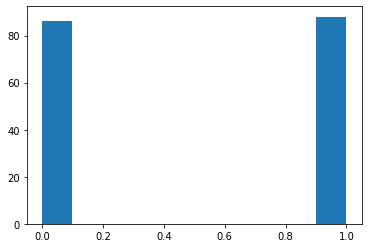

In [11]:
plt.hist(data_abundance_Cirrhosis['Cirrhosis'])

In [12]:
data_abundance_Obesity.shape

(189, 471)

(array([ 66.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 123.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

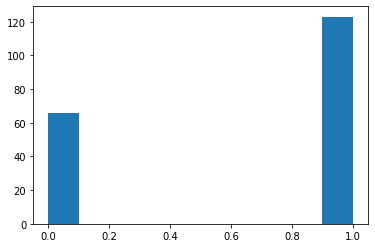

In [13]:
plt.hist(data_abundance_Obesity['Obesity'])
#Podemos ver un claro desbalance en las etiquetas de obesidad 

In [14]:
data_abundance_Diabetes.shape

(258, 578)

(array([130.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 128.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

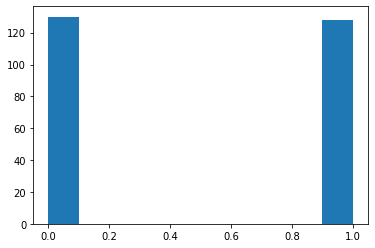

In [15]:
plt.hist(data_abundance_Diabetes['Diabetes'])

In [16]:
#data_abundance_Obesity=data_abundance.drop(list(set(data_abundance.columns)-(common_columns|set(['Obesity']))),axis=1)
#data_abundance_Obesity=data_abundance_Obesity.dropna(subset=["Obesity"])
#data_abundance_Obesity=data_abundance_Obesity.dropna(axis=1)

In [17]:
#data_abundance_Diabetes_aux=data_abundance.drop(list(set(data_abundance.columns)-(common_columns|set(['Diabetes']))),axis=1)
#data_abundance_Diabetes_aux=data_abundance_Diabetes_aux.dropna(subset=["Diabetes"])
#data_abundance_Diabetes_aux=data_abundance_Diabetes_aux.dropna(axis=1)

In [18]:
#equi_obesidad= data_abundance_Diabetes_aux[data_abundance_Diabetes_aux['Diabetes']==0][0:60]
#equi_obesidad['Obesity']=equi_obesidad['Diabetes']
#equi_obesidad=equi_obesidad.drop(['Diabetes'],axis=1)

In [19]:
#X=data_abundance.drop(list(set(data_abundance.columns)-common_columns),axis=1)
#y_Cirrhosis = data_abundance['Cirrhosis']
#y_Obesity = data_abundance['Obesity']
#y_Diabetes = data_abundance['Diabetes']

# *Modelos (Enfoque un modelo multi clase para todas la enfermedades)

In [20]:
data_abundance_aux=data_abundance.drop(list(set(data_abundance.columns)-common_columns),axis=1)
data_abundance_aux['Cirrhosis']=data_abundance['Cirrhosis']
data_abundance_aux['Obesity']=data_abundance['Obesity']*2
data_abundance_aux['Diabetes']=data_abundance['Diabetes']*3

In [21]:
data_abundance_aux['Cirrhosis'] = data_abundance_aux['Cirrhosis'].fillna(0)
data_abundance_aux['Obesity'] = data_abundance_aux['Obesity'].fillna(0)
data_abundance_aux['Diabetes'] = data_abundance_aux['Diabetes'].fillna(0)

In [22]:
data_abundance_aux['enfermedades']=data_abundance_aux['Cirrhosis']+data_abundance_aux['Obesity']+data_abundance_aux['Diabetes']

In [23]:
data_abundance_aux=data_abundance_aux.drop(['Cirrhosis','Obesity','Diabetes'],axis=1)

In [24]:
y_enfermedades = data_abundance_aux['enfermedades']
X_enfermedades = data_abundance_aux.drop(['enfermedades'], axis=1)
lda = LinearDiscriminantAnalysis(n_components=3)
lda.fit(X_enfermedades, y_enfermedades)
X_enfermedades_lda = lda.transform(X_enfermedades)
X_train, X_val, y_train, y_val = train_test_split(X_enfermedades,y_enfermedades,test_size=0.3, random_state=44, stratify=y_enfermedades)

In [25]:
lda = LinearDiscriminantAnalysis(n_components=3)
lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)
X_val_lda = lda.transform(X_val)

####  -SVM

In [26]:
clfv = svm.SVC(C=0.5,kernel='linear')

In [27]:
clfv.fit(X_train_lda, y_train)
y_pred=clfv.predict(X_val_lda)

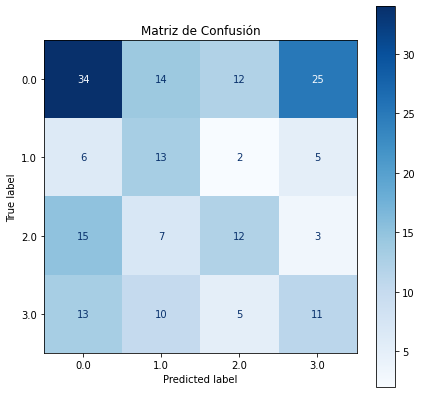

In [28]:
cm=confusion_matrix(y_val,y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(data_abundance_aux['enfermedades'])))
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

In [29]:
roc_auc_score(pd.get_dummies(y_val),pd.get_dummies(y_pred),multi_class='ovr')

0.5788570061939627

In [30]:
X_enfermedades_lda.shape

(621, 3)

In [31]:
y_enfermedades.shape

(621,)

In [32]:
scores=random_seeds_model(32,X_enfermedades,y_train,clfv)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

ValueError: Found input variables with inconsistent numbers of samples: [621, 434]

In [ ]:
X_enfermedades_lda

In [ ]:
explora_lda=pd.concat([pd.DataFrame(X_enfermedades),pd.DataFrame(y_enfermedades)],axis=1)

In [ ]:
for i in explora_lda.columns:  
    fig, ax = plt.subplots(figsize=(3, 3))
    sns.distplot(explora_lda[i])
    sns.distplot(explora_lda[i])
    plt.show()

### Random forest

In [ ]:
clf = RandomForestClassifier(max_depth=50, random_state=44)
clf.fit(X_train, y_train)

In [ ]:
X_train.shape

In [ ]:
y_pred=clf.predict(X_val)

In [ ]:
cm=confusion_matrix(y_val,y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(data_abundance_aux['enfermedades'])))
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

In [ ]:
roc_auc_score(pd.get_dummies(y_val),pd.get_dummies(y_pred),multi_class='ovr')

In [ ]:
scores=random_seeds_model(32,X_enfermedades_lda,y_enfermedades,clf)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

### Logistico

In [ ]:
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train,y_train)

In [ ]:
y_pred=logistic_reg.predict(X_val)

In [ ]:
cm=confusion_matrix(y_val,y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(data_abundance_aux['enfermedades'])))
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

In [ ]:
roc_auc_score(pd.get_dummies(y_val),pd.get_dummies(y_pred),multi_class='ovr')

In [ ]:
scores=random_seeds_model(64,X_enfermedades,y_enfermedades,logistic_reg)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

### Gradient boosting classifier

In [ ]:
GB = GradientBoostingClassifier(n_estimators=50, learning_rate=0.7, max_depth=5, random_state=0).fit(X_train, y_train)

In [ ]:
y_pred=GB.predict(X_val)

In [ ]:
cm=confusion_matrix(y_val,y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(data_abundance_aux['enfermedades'])))
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

In [ ]:
roc_auc_score(pd.get_dummies(y_val),pd.get_dummies(y_pred),multi_class='ovr')

In [ ]:
scores=random_seeds_model(32,X_train,y_train,GB)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

# *Modelos (Enfoque un modelo binario por enfermedad)

### -Cirrhosis

In [ ]:
y_Cirrhosis = data_abundance_Cirrhosis['Cirrhosis']
X_Cirrhosis = data_abundance_Cirrhosis.drop(['Unnamed: 0','country','code_study','Cirrhosis'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_Cirrhosis,y_Cirrhosis,test_size=0.3, random_state=105)

In [ ]:
y_Cirrhosis_aux = data_abundance_Cirrhosis['Cirrhosis']
X_Cirrhosis_aux = data_abundance_Cirrhosis.drop(list(set(list(data_abundance_Cirrhosis.columns))-set(common_columns)), axis=1)

In [ ]:
columnas_Cirrhosis=set(list(X_Cirrhosis.columns))

In [ ]:
X_train.shape

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)
X_val_lda = lda.transform(X_val)

In [ ]:
X_train_lda

####  -SVM

In [ ]:
clfv = svm.SVC(C=0.5,kernel='linear')

In [ ]:
clfv.fit(X_train, y_train)
y_pred=clfv.predict(X_val)

In [ ]:
cm=confusion_matrix(y_val,y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(data_abundance_Cirrhosis['Cirrhosis'])))
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

In [ ]:
roc_auc_score(pd.get_dummies(y_val),pd.get_dummies(y_pred))

In [ ]:
scores=random_seeds_model(64,X_Cirrhosis,y_Cirrhosis,clfv)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

In [ ]:
scores=random_seeds_model(64,X_Cirrhosis_aux,y_Cirrhosis_aux,clfv)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

#### -Random Forest

In [ ]:
clf = RandomForestClassifier(max_depth=50, random_state=44)
clf.fit(X_train_lda, y_train)

In [ ]:
clf = RandomForestClassifier(max_depth=100, random_state=44)
clf.fit(X_train, y_train)

In [ ]:
y_pred=clf.predict(X_val_lda)

In [ ]:
cm=confusion_matrix(y_val,y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(data_abundance_Cirrhosis['Cirrhosis'])))
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

In [ ]:
roc_auc_score(pd.get_dummies(y_val),pd.get_dummies(y_pred))

In [ ]:
scores=random_seeds_model(64,X_Cirrhosis,y_Cirrhosis,clf)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

In [ ]:
scores=random_seeds_model(64,X_Cirrhosis_aux,y_Cirrhosis_aux,clf)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

#### Clasificador Logistico 

In [ ]:
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train,y_train)

In [ ]:
y_pred=logistic_reg.predict(X_val)

In [ ]:
cm=confusion_matrix(y_val,y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(data_abundance_Cirrhosis['Cirrhosis'])))
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

In [ ]:
roc_auc_score(pd.get_dummies(y_val),pd.get_dummies(y_pred))

In [ ]:
scores=random_seeds_model(64,X_Cirrhosis,y_Cirrhosis,logistic_reg)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

In [ ]:
scores=random_seeds_model(64,X_Cirrhosis_aux,y_Cirrhosis_aux,logistic_reg)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

### -Obesity

In [ ]:
#y_Obesity =list(data_abundance_Obesity['Obesity'])+list(equi_obesidad['Obesity'])
#X_Obesity = pd.concat([data_abundance_Obesity.drop(['Obesity'], axis=1),equi_obesidad.drop(['Obesity'], axis=1)])
#X_train, X_val, y_train, y_val = train_test_split(X_Obesity,y_Obesity,test_size=0.3, random_state=17, stratify=y_Obesity)

In [ ]:
y_Obesity = data_abundance_Obesity['Obesity']
X_Obesity = data_abundance_Obesity.drop(['Unnamed: 0','country','code_study','Obesity'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X_Obesity,y_Obesity,test_size=0.2, random_state=90, stratify=y_Obesity)

In [ ]:
columnas_Obesity=set(list(X_Obesity.columns))

In [ ]:
y_Obesity_aux = data_abundance_Obesity['Obesity']
X_Obesity_aux = data_abundance_Obesity.drop(list(set(list(data_abundance_Obesity.columns))-set(common_columns)), axis=1)

#### -SVM

In [ ]:
clfv = svm.SVC(C=0.3,kernel='linear')

In [ ]:
clfv.fit(X_train, y_train)
y_pred=clfv.predict(X_val)

In [ ]:
cm=confusion_matrix(y_val,y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(data_abundance_Obesity['Obesity'])))
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

In [ ]:
roc_auc_score(pd.get_dummies(y_val),pd.get_dummies(y_pred))

In [ ]:
scores=random_seeds_model(64,X_Obesity,y_Obesity,clfv)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

In [ ]:
scores=random_seeds_model(64,X_Obesity_aux,y_Obesity_aux,clfv)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

#### Random Forest Clasifier

In [ ]:
clf = RandomForestClassifier(max_depth=50, random_state=44)
clf.fit(X_train, y_train)

In [ ]:
y_pred=clf.predict(X_val)

In [ ]:
cm=confusion_matrix(y_val,y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(data_abundance_Obesity['Obesity'])))
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

In [ ]:
roc_auc_score(pd.get_dummies(y_val),pd.get_dummies(y_pred))

In [ ]:
scores=random_seeds_model(64,X_Obesity,y_Obesity,clf)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

In [ ]:
scores=random_seeds_model(64,X_Obesity_aux,y_Obesity_aux,clf)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

#### Clasificador Logistico 

In [ ]:
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train,y_train)

In [ ]:
y_pred=logistic_reg.predict(X_val)

In [ ]:
cm=confusion_matrix(y_val,y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(data_abundance_Obesity['Obesity'])))
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

In [ ]:
roc_auc_score(pd.get_dummies(y_val),pd.get_dummies(y_pred))

In [ ]:
scores=random_seeds_model(64,X_Obesity,y_Obesity,logistic_reg)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

In [ ]:
scores=random_seeds_model(64,X_Obesity_aux,y_Obesity_aux,logistic_reg)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

#### Gradient boosting classifier

In [ ]:
GB = GradientBoostingClassifier(n_estimators=200, learning_rate=0.7, max_depth=25, random_state=0).fit(X_train, y_train)

In [ ]:
y_pred=GB.predict(X_val)

In [ ]:
cm=confusion_matrix(y_val,y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(data_abundance_Obesity['Obesity'])))
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

In [ ]:
roc_auc_score(pd.get_dummies(y_val),pd.get_dummies(y_pred))

In [ ]:
scores=random_seeds_model(32,X_Obesity,y_Obesity,GB)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

In [ ]:
scores=random_seeds_model(32,X_Obesity_aux,y_Obesity_aux,GB)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

### -Diabetes

In [ ]:
y_Diabetes = data_abundance_Diabetes['Diabetes']
X_Diabetes = data_abundance_Diabetes.drop(['Unnamed: 0','country','code_study','Diabetes'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X_Diabetes,y_Diabetes,test_size=0.3, random_state=44, stratify=y_Diabetes)

In [ ]:
y_Diabetes_aux = data_abundance_Diabetes['Diabetes']
X_Diabetes_aux = data_abundance_Diabetes.drop(list(set(list(data_abundance_Diabetes.columns))-set(common_columns)), axis=1)

In [ ]:
columnas_Diabetes=set(list(X_Diabetes.columns))

#### -SVM

In [ ]:
clfv = svm.SVC(kernel='linear')

In [ ]:
clfv.fit(X_train, y_train)
y_pred=clfv.predict(X_val)

In [ ]:
cm=confusion_matrix(y_val,y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(data_abundance_Diabetes['Diabetes'])))
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

In [ ]:
roc_auc_score(pd.get_dummies(y_val),pd.get_dummies(y_pred))

In [ ]:
scores=random_seeds_model(32,X_Diabetes,y_Diabetes,clfv)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

In [ ]:
scores=random_seeds_model(32,X_Diabetes_aux,y_Diabetes_aux,clfv)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

#### Random Forest Clasifier

In [ ]:
clf = RandomForestClassifier(max_depth=100, random_state=44)
clf.fit(X_train, y_train)

In [ ]:
y_pred=clf.predict(X_val)

In [ ]:
cm=confusion_matrix(y_val,y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(data_abundance_Diabetes['Diabetes'])))
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

In [ ]:
roc_auc_score(pd.get_dummies(y_val),pd.get_dummies(y_pred))

In [ ]:
scores=random_seeds_model(32,X_Diabetes,y_Diabetes,clf)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

In [ ]:
scores=random_seeds_model(32,X_Diabetes_aux,y_Diabetes_aux,clf)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

#### Clasificador Logistico 

In [ ]:
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train,y_train)

In [ ]:
y_pred=logistic_reg.predict(X_val)

In [ ]:
cm=confusion_matrix(y_val,y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(data_abundance_Diabetes['Diabetes'])))
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

In [ ]:
roc_auc_score(pd.get_dummies(y_val),pd.get_dummies(y_pred))

In [ ]:
scores=random_seeds_model(32,X_Diabetes,y_Diabetes,logistic_reg)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

In [ ]:
scores=random_seeds_model(32,X_Diabetes_aux,y_Diabetes_aux,logistic_reg)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

#### Gradient boosting classifier

In [ ]:
GB = GradientBoostingClassifier(n_estimators=10, learning_rate=1.7, max_depth=15, random_state=0).fit(X_train, y_train)

In [ ]:
y_pred=GB.predict(X_val)

In [ ]:
cm=confusion_matrix(y_val,y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(data_abundance_Obesity['Obesity'])))
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

In [ ]:
roc_auc_score(pd.get_dummies(y_val),pd.get_dummies(y_pred))

In [ ]:
scores=random_seeds_model(32,X_Diabetes,y_Diabetes,GB)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

In [ ]:
scores=random_seeds_model(32,X_Diabetes_aux,y_Diabetes_aux,GB)
print('promedio: ',np.mean(scores),' Varianza: ',np.var(scores))

# *Submittion

In [ ]:
data_abundance_test = pd.read_csv("biomedata_test_abundance.csv")

In [ ]:
summit=pd.read_csv("master_biome_sample.csv")

In [ ]:
gender=pd.get_dummies(data_abundance_test['gender'])
data_abundance_test['gender']=gender['male']
data_abundance_test['-']=gender['-']

In [ ]:
summit.set_index('Id',inplace = True)

## Submittion un modelo multiclase para todas las enfermedades

In [ ]:
data_abundance_test_aux=data_abundance_test.drop(list(set(data_abundance_test.columns)-common_columns),axis=1)

In [ ]:
clf = RandomForestClassifier(max_depth=50, random_state=44)
clf.fit(lda.transform(X_enfermedades), y_enfermedades)

In [ ]:
X_enfermedades_lda

In [ ]:
logistic_reg = LogisticRegression()
logistic_reg.fit(X_enfermedades_lda,y_enfermedades)

In [ ]:
lda.transform(X_enfermedades)

In [ ]:
y_pred=clf.predict(lda.transform(data_abundance_test_aux))

In [ ]:
y_pred=logistic_reg.predict(lda.transform(data_abundance_test_aux))

In [ ]:
y_pred_Cirrhosis=[]
y_pred_Obesity=[]
y_pred_Diabetes=[]
for i in y_pred:
    if i==0:
        y_pred_Cirrhosis.append(0)
        y_pred_Obesity.append(0)
        y_pred_Diabetes.append(0)
    elif i==1:
        y_pred_Cirrhosis.append(1)
        y_pred_Obesity.append(0)
        y_pred_Diabetes.append(0)
    elif i==2:
        y_pred_Cirrhosis.append(0)
        y_pred_Obesity.append(1)
        y_pred_Diabetes.append(0)
    else:
        y_pred_Cirrhosis.append(0)
        y_pred_Obesity.append(0)
        y_pred_Diabetes.append(1)
        
        
        

In [ ]:
summit['Cirrhosis']=y_pred_Cirrhosis
summit['Obesity']=y_pred_Obesity
summit['Diabetes']=y_pred_Diabetes

In [ ]:
summit

In [ ]:
summit.to_csv('sample_submission_multiclass_logistic_LDA.csv')

## Submittion un modelo binario por enfermedad

In [ ]:
data_abundance_test_aux=data_abundance_test.drop(list(set(data_abundance_test.columns)-common_columns),axis=1)

In [ ]:
data_abundance_Cirrhosis_test =data_abundance_test.drop(list(set(data_abundance_test.columns)-columnas_Cirrhosis),axis=1)
data_abundance_Cirrhosis_test=data_abundance_Cirrhosis_test.dropna()
data_abundance_Obesity_test =data_abundance_test.drop(list(set(data_abundance_test.columns)-columnas_Obesity),axis=1).dropna()
data_abundance_Obesity_test=data_abundance_Obesity_test.dropna()
data_abundance_Diabetes_test =data_abundance_test.drop(list(set(data_abundance_test.columns)-columnas_Diabetes),axis=1).dropna()
data_abundance_Diabetes_test=data_abundance_Diabetes_test.dropna()

In [ ]:
#data_abundance_Obesity_test =data_abundance_test.drop(list(set(data_abundance_test.columns)-common_columns),axis=1).dropna()
#data_abundance_Obesity_test=data_abundance_Obesity_test.dropna()

In [ ]:
#data_abundance_Cirrhosis_test =data_abundance_test.drop(list(set(data_abundance_test.columns)-common_columns),axis=1)
#data_abundance_Cirrhosis_test=data_abundance_Cirrhosis_test.dropna()
#data_abundance_Obesity_test =data_abundance_test.drop(list(set(data_abundance_test.columns)-common_columns),axis=1).dropna()
#data_abundance_Obesity_test=data_abundance_Obesity_test.dropna()
#data_abundance_Diabetes_test =data_abundance_test.drop(list(set(data_abundance_test.columns)-common_columns),axis=1).dropna()
#data_abundance_Diabetes_test=data_abundance_Diabetes_test.dropna()

In [ ]:
#logistic_reg = LogisticRegression()
#logistic_reg.fit(X[:174],y_Cirrhosis[:174])
#y_pred_Cirrhosis=logistic_reg.predict(data_abundance_test_aux)

In [ ]:
#logistic_reg = LogisticRegression()
#logistic_reg.fit(X[175:363],y_Obesity[175:363])
#y_pred_Obesity=logistic_reg.predict(data_abundance_test_aux)

In [ ]:
#logistic_reg = LogisticRegression()
#logistic_reg.fit(X[364:622],y_Diabetes[364:622])
#y_pred_Diabetes=logistic_reg.predict(data_abundance_test_aux)

## -Cirrhosis

### Random Forest

In [ ]:
clf = RandomForestClassifier(max_depth=100, random_state=44)
clf.fit(X_Cirrhosis, y_Cirrhosis)

In [ ]:
y_pred_Cirrhosis=clf.predict(data_abundance_Cirrhosis_test)

### -SVM

In [ ]:
clfv = svm.SVC(C=0.5,kernel='linear')

In [ ]:
clfv.fit(X_Cirrhosis, y_Cirrhosis)
y_pred_Cirrhosis=clfv.predict(data_abundance_Cirrhosis_test)

### Logistico

In [ ]:
logistic_reg = LogisticRegression()
logistic_reg.fit(X_Cirrhosis,y_Cirrhosis)

In [ ]:
X_test_Cirrhosis=data_abundance_Cirrhosis_test.drop([], axis=1)

In [ ]:
y_pred_Cirrhosis=logistic_reg.predict(data_abundance_Cirrhosis_test)

## -Obesity

### Random Forest

In [ ]:
clf = RandomForestClassifier(max_depth=100, random_state=44)
clf.fit(X_Obesity, y_Obesity)

In [ ]:
y_pred_Obesity=clf.predict(data_abundance_Obesity_test)

### SVM

In [ ]:
clfv = svm.SVC(C=0.5,kernel='linear')

In [ ]:
clfv.fit(X_Obesity, y_Obesity)
y_pred_Obesity=clfv.predict(data_abundance_Obesity_test)

### Logistico

In [ ]:
logistic_reg = LogisticRegression()
logistic_reg.fit(X_Obesity,y_Obesity)

In [ ]:
y_pred_Obesity=logistic_reg.predict(data_abundance_Obesity_test)

## -Diabetes

### Random Forest

In [ ]:
clf = RandomForestClassifier(max_depth=200, random_state=44)
clf.fit(X_Diabetes, y_Diabetes)

In [ ]:
y_pred_Diabetes=clf.predict(data_abundance_Diabetes_test)

### SVM

In [ ]:
clfv = svm.SVC(C=0.5,kernel='linear')

In [ ]:
clfv.fit(X_Diabetes, y_Diabetes)
y_pred_Diabetes=clfv.predict(data_abundance_Diabetes_test)

### Logistico

In [ ]:
logistic_reg = LogisticRegression()
logistic_reg.fit(X_Diabetes,y_Diabetes)

In [ ]:
y_pred_Diabetes=logistic_reg.predict(data_abundance_Diabetes_test)

## Fabricando las listas 

### -Cirrhosis

In [ ]:
Cirrhosis=[]
for i in range(summit.shape[0]):
    if i in range(58):
        Cirrhosis.append(y_pred_Cirrhosis[i])
    else:
        Cirrhosis.append(0)      

### -Obesity

In [ ]:
Obesity=[]
for i in range(summit.shape[0]):
    if i in range(58,122):
        Obesity.append(y_pred_Obesity[i-58])
    else:
        Obesity.append(0)    

### -Diabetes

In [ ]:
Diabetes=[]
for i in range(summit.shape[0]):
    if i in range(122,208):
        Diabetes.append(y_pred_Diabetes[i-122])
    else:
        Diabetes.append(0)  

## Finalizando summit

In [ ]:
summit['Cirrhosis']=Cirrhosis
summit['Obesity']=Obesity
summit['Diabetes']=Diabetes


In [ ]:
#summit['Cirrhosis']=y_pred_Cirrhosis
#summit['Obesity']=y_pred_Obesity
#summit['Diabetes']=y_pred_Diabetes

In [ ]:
summit.to_csv('sample_submission_final.csv')